# Edit distance search
Manipulating inference results, creating training and testing labels

In [104]:
%load_ext autoreload
%autoreload 2

In [13]:
import pandas as pd
from tqdm import tqdm
import os

In [111]:
basepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\edit_distance_motif_search\res-loose-chain.txt"

In [94]:
def clean_prediction(edit_motif_search_prediction):

    cleaned_prediction = []
    for i in edit_motif_search_prediction:
        if i == 'fake':
            cleaned_prediction.append([])
        else:
            cleaned_prediction.append([int(i[1])])

    return cleaned_prediction

In [95]:

def get_edit_dataframe(edit_inference_filename):

    with open(edit_inference_filename, 'r') as f:
        lines = f.readlines()

    motif_predictions = []
    orientations = []
    read_ids = []
    ont_barcode = []

    for line in tqdm(lines):
        split_line = line.split()
        read_id = split_line[0][3:]
        orientation = split_line[1]
        prediction = split_line[4][8:].split('->')
        if not (prediction[0].startswith('f') or prediction[0].startswith('m')):
            prediction = prediction[1:]

        cleaned_prediction = clean_prediction(prediction)
        
        motif_predictions.append(cleaned_prediction)
        orientations.append(orientation)
        read_ids.append(read_id)
    
    df = pd.DataFrame({"read_id": read_ids, "orientation": orientations, "motif_seq": motif_predictions})
    df = df.drop_duplicates(subset=['read_id'])
    return df

In [112]:
df = get_edit_dataframe(basepath)

100%|██████████| 590137/590137 [00:06<00:00, 87997.00it/s] 


In [113]:
dil = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\diluted_EIC04.pkl")

In [114]:
merged = pd.merge(dil, df, on='read_id')

In [115]:
len(merged)

7168

In [102]:
merged

,read_id,ONT_Barcode,HW_Address,orientation,start_end,library_motif,payload,motif_seq
0,7b39274b-81b1-4805-a9fc-190bb8d891d3,46,barcode_external01_internal01,+,169-218,ltm8_9x4,"[[1, 2, 4, 5], [2, 4, 6, 7], [1, 2, 4, 7], [2,...","[[], [], [], [], [], [], [], [1], [4], [7]]"
1,924ac149-e623-4720-a0fb-a987a24002e0,46,barcode_external01_internal01,+,160-209,ltm8_2x1,"[[1, 2, 4, 5], [2, 4, 6, 7], [1, 2, 4, 7], [2,...","[[1], [1], [4], [7], [], [], [], [], [], []]"
2,a6a50746-43fa-4d6c-8e1c-4fd7c607d43b,46,barcode_external01_internal01,+,449-498,ltm8_9x1,"[[1, 2, 4, 5], [2, 4, 6, 7], [1, 2, 4, 7], [2,...","[[], [], [], [], [1], [5], [], [3], [1], [1]]"
3,00a5e32f-6e95-47c6-b009-4ce1bcc8d812,46,barcode_external01_internal03,+,285-334,ltm8_6x8,"[[2, 5, 6, 8], [2, 3, 6, 8], [1, 3, 5, 8], [2,...","[[], [], [], [], [8], [8], [1], [3], [], []]"
4,9438a513-1fcb-4cb2-a1b3-84c62c5541a7,46,barcode_external01_internal03,+,85-134,ltm8_6x4,"[[2, 5, 6, 8], [2, 3, 6, 8], [1, 3, 5, 8], [2,...","[[], [], [], [], [], [4], [1], [3], [6], []]"
...,...,...,...,...,...,...,...,...
792,63d17596-dedf-404a-af20-b00d857825ba,80,barcode_external07_internal01,-,89-138,ltm8_7x7,"[[3, 4, 6, 7], [1, 4, 5, 8], [2, 3, 7, 8], [5,...","[[7], [1], [7], [1], [7], [7], [7], [], [], []]"
793,3dfcebf6-cd15-481d-9737-9c7e3f72bc37,80,barcode_external07_internal04,+,306-355,ltm8_6x5,"[[2, 3, 5, 8], [1, 2, 6, 8], [2, 3, 6, 7], [5,...","[[], [], [], [2], [6], [5], [4], [5], [], []]"
794,f5bb5068-f5ac-4273-a175-e0cb9708e71f,80,barcode_external07_internal05,-,350-399,ltm8_5x4,"[[1, 3, 4, 6], [3, 5, 7, 8], [1, 2, 4, 8], [2,...","[[7], [5], [3], [7], [4], [4], [3], [6], [5], []]"
795,860a94f3-088c-426a-a3b7-85f4d9f7d8e8,80,barcode_external07_internal07,+,110-159,ltm8_1x7,"[[2, 3, 5, 8], [1, 3, 5, 6], [2, 3, 5, 6], [2,...","[[7], [7], [3], [], [5], [5], [3], [], [], []]"


In [22]:
merged['ONT_Barcode'].unique()

array([46, 66, 74, 78, 47, 67, 75, 79, 48, 68, 76, 80])

In [23]:
master_df = pd.DataFrame()

for file in tqdm(os.listdir(basepath)):
    df = get_edit_dataframe(os.path.join(basepath, file))
    master_df = pd.concat([master_df, df])

100%|██████████| 10/10 [00:00<00:00, 11.23it/s]


In [10]:
master_df.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\01-04run\edit_medium.pkl")

## Balancing edit-train df

In [5]:
from data_functions import get_cleaned_encoded_file

In [6]:
encoded_df = pd.read_csv(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\EIC01-01-1280-T1_encoded.tsv", sep='\t')

In [136]:
t = get_cleaned_encoded_file(encoded_df)

In [137]:
t = t[['ONT_Barcode', 'HW_Address', 'payload']]

In [9]:
t

,ONT_Barcode,HW_Address,payload
0,1,barcode_external01_internal01,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,..."
1,1,barcode_external02_internal01,"[[3, 4, 7, 8], [2, 3, 4, 8], [2, 4, 6, 7], [1,..."
2,1,barcode_external03_internal01,"[[1, 3, 5, 8], [2, 4, 5, 6], [1, 5, 6, 8], [1,..."
3,1,barcode_external04_internal01,"[[1, 4, 5, 8], [3, 4, 7, 8], [1, 4, 7, 8], [1,..."
4,1,barcode_external05_internal01,"[[2, 4, 5, 6], [3, 4, 6, 7], [4, 5, 6, 8], [1,..."
...,...,...,...
1275,77,barcode_external04_internal08,"[[1, 2, 3, 6], [2, 4, 5, 7], [1, 3, 4, 7], [1,..."
1276,77,barcode_external05_internal08,"[[4, 6, 7, 8], [1, 2, 4, 8], [3, 4, 5, 7], [2,..."
1277,77,barcode_external06_internal08,"[[1, 4, 7, 8], [4, 6, 7, 8], [1, 2, 4, 8], [2,..."
1278,77,barcode_external07_internal08,"[[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1,..."


In [10]:
edit_train_df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\edit_master_train.pkl")

In [11]:
edit_train_df.head()

,read_id,ONT_Barcode,HW_Address,orientation,start_end,library_motif,squiggle,motif_seq,strand,payload_motifs_found,edit_spacer_seq,edit_motifs_found,payload
0,0117ec74-7ef1-4e8c-b169-c8ca9a576de4,barcode01,barcode_external01_internal01,+|+|+,75-124|370-419|566-615,ltm8_2x1|ltm8_5x4|ltm8_9x1,"[452, 439, 450, 444, 451, 454, 471, 448, 418, ...","[10, 1, 10, 13, 4, 13, 17, 1, 17]",+,3,"[10, 1, 10, 11, 1, 11, 12, 3, 12, 13, 1, 13, 1...",9.0,"[[2, 3, 4, 5], [1, 2, 7, 8], [1, 4, 5, 6], [4,..."
1,0117ec74-7ef1-4e8c-b169-c8ca9a576de4,barcode01,barcode_external01_internal01,+|+|+,75-124|370-419|566-615,ltm8_2x1|ltm8_5x4|ltm8_9x1,"[452, 439, 450, 444, 451, 454, 471, 448, 418, ...","[10, 1, 10, 13, 4, 13, 17, 1, 17]",+,3,"[10, 1, 10, 11, 1, 11, 12, 3, 12, 13, 1, 13, 1...",9.0,"[[3, 6, 7, 8], [3, 4, 5, 8], [1, 2, 4, 6], [1,..."
2,0117ec74-7ef1-4e8c-b169-c8ca9a576de4,barcode01,barcode_external01_internal01,+|+|+,75-124|370-419|566-615,ltm8_2x1|ltm8_5x4|ltm8_9x1,"[452, 439, 450, 444, 451, 454, 471, 448, 418, ...","[10, 1, 10, 13, 4, 13, 17, 1, 17]",+,3,"[10, 1, 10, 11, 1, 11, 12, 3, 12, 13, 1, 13, 1...",9.0,"[[1, 2, 4, 5], [2, 4, 5, 6], [2, 5, 6, 8], [2,..."
3,0117ec74-7ef1-4e8c-b169-c8ca9a576de4,barcode01,barcode_external01_internal01,+|+|+,75-124|370-419|566-615,ltm8_2x1|ltm8_5x4|ltm8_9x1,"[452, 439, 450, 444, 451, 454, 471, 448, 418, ...","[10, 1, 10, 13, 4, 13, 17, 1, 17]",+,3,"[10, 1, 10, 11, 1, 11, 12, 3, 12, 13, 1, 13, 1...",9.0,"[[2, 3, 4, 8], [3, 5, 6, 7], [2, 3, 7, 8], [2,..."
4,0117ec74-7ef1-4e8c-b169-c8ca9a576de4,barcode01,barcode_external01_internal01,+|+|+,75-124|370-419|566-615,ltm8_2x1|ltm8_5x4|ltm8_9x1,"[452, 439, 450, 444, 451, 454, 471, 448, 418, ...","[10, 1, 10, 13, 4, 13, 17, 1, 17]",+,3,"[10, 1, 10, 11, 1, 11, 12, 3, 12, 13, 1, 13, 1...",9.0,"[[1, 4, 5, 6], [1, 5, 6, 8], [1, 3, 6, 8], [2,..."


In [12]:
edit_train_df = edit_train_df.drop(columns=['payload'])

In [13]:
edit_train_df['ONT_Barcode'] = edit_train_df['ONT_Barcode'].apply(lambda x: int(x[-2:]))

In [138]:
merged_df = pd.merge(filtered_df, t, on=['ONT_Barcode', 'HW_Address'])

Steps
1. Filter out reads where more than 8 motifs are identified
2. Keep the ones with no error
3. For the ones with error, check motif search label and encoded to make the perfect label with no errors
4. Double check that there are no errors for the whole dataset
5. Keep the address motifs identified
6. Some data of the distribution of reads

In [30]:
filtered_df = merged_df.loc[merged_df['edit_motifs_found'] > 9]

In [19]:
from transcript_sorting import sort_transcript_with_address
from utils import evaluate_prediction, create_spacer_sequence_with_address

In [142]:
filtered_df['edit_payload_seq'] = filtered_df['edit_spacer_seq'].apply(lambda x: sort_transcript_with_address(x))

C:\Users\Parv\AppData\Local\Temp\ipykernel_16804\3654313105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['edit_payload_seq'] = filtered_df['edit_spacer_seq'].apply(lambda x: sort_transcript_with_address(x))


In [33]:
def remove_erroneous_motifs(prediction, original):
    corrected = [[] for i in range(8)]

    cycle_num = 0
    for i, j in zip(prediction, original):
        for k in i:
            if k in j:
                corrected[cycle_num].append(k)
        cycle_num += 1
    return corrected

In [72]:
from tqdm import tqdm

In [74]:
filtered_df.columns

Index(['read_id', 'ONT_Barcode', 'HW_Address', 'orientation', 'start_end',
       'library_motif', 'squiggle', 'motif_seq', 'strand',
       'payload_motifs_found', 'edit_spacer_seq', 'edit_motifs_found',
       'payload', 'edit_payload_seq'],
      dtype='object')

In [141]:
merged_df.columns

Index(['read_id', 'ONT_Barcode', 'HW_Address', 'orientation', 'start_end',
       'library_motif', 'squiggle', 'motif_seq', 'strand',
       'payload_motifs_found', 'edit_spacer_seq', 'edit_motifs_found',
       'payload_x', 'payload_y'],
      dtype='object')

In [145]:
counter = 0
mf = 0
me = 0
corrected_edit_payload_seq = []
unique_predictions = set()

edit_seqs = []
spacer_seqs = []
read_ids = []
payloads = []
squiggles = []
orientation = []

for ind, row in tqdm(filtered_df.iterrows(), total=len(filtered_df)):
    i = row['edit_payload_seq']
    j = row['payload']
    k = row['edit_spacer_seq']
    read_id = row['read_id']



    if str(i) not in unique_predictions:
        metrics = evaluate_prediction(i[2:], j)
        if metrics[1] > 0:
            continue
        mf += metrics[0]
        me += metrics[1]
        read_ids.append(read_id)
        edit_seqs.append(i)
        spacer_seqs.append(k)
        unique_predictions.add(str(i))
    #final = i[:2] + corrected
    #print(i)
    #print(final)
    #print()
    #corrected_edit_payload_seq.append(final)

100%|██████████| 110274/110274 [00:06<00:00, 17521.52it/s]


In [149]:
filtered_df = filtered_df.loc[filtered_df['read_id'].isin(read_ids)]

In [150]:
len(filtered_df)

90534

In [103]:
forward_df = filtered_df_.loc[filtered_df_['read_id'].isin(read_ids)]

In [105]:
forward_df = forward_df.loc[forward_df['orientation'].str.startswith('+')]

In [153]:
filtered_df.to_pickle(r'C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\edit_distance_motif_search\edit_train_filtered_reverse.pkl')

In [81]:
len(merged_unique_df)

2936700

In [68]:
t = [str(i) for i in filtered_df['edit_payload_seq'].to_list()[:2942440]]

In [157]:
filtered_reverse = filtered_df.loc[filtered_df['orientation'].str.startswith('-')]

In [160]:
filtered_reverse['edit_spacer_seq'] = filtered_reverse['edit_spacer_seq'].apply(lambda x: x[::-1])

C:\Users\Parv\AppData\Local\Temp\ipykernel_4900\2773630298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reverse['edit_spacer_seq'] = filtered_reverse['edit_spacer_seq'].apply(lambda x: x[::-1])


In [ ]:
filtered_forward['edit_spacer_seq'] = filtered_df['edit_payload_seq_no_error'].apply()

In [166]:
filtered_reverse.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\edit_distance_motif_search\edit_train_filtered_reverse.pkl")

In [167]:
filtered_forward = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\edit_distance_motif_search\edit_train_filtered_forward.pkl")

### Adding edit labels to test dataset

In [3]:
edit_df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\edit_distance_motif_search\edit_distance_motif_search.pkl")

In [4]:
edit_df

,read_id,orientation,motif_seq
0,7f177924-d279-4de6-bb86-01eaec9ee0e5,-,"[[3], [5], [2], [3], [], [], [], [], [], []]"
1,d47257cc-0209-450d-8b15-8c99a82dd1c4,-,"[[1], [8], [2], [5], [1], [5], [], [], [], []]"
2,6bf40594-e818-401a-a7f4-142b51615a14,-,"[[4], [2], [2], [1], [], [], [], [], [], []]"
3,07126fb4-14ef-4d7c-8be0-491c44e4ea8a,+,"[[1], [6], [6], [4], [], [], [], [], [], [8]]"
4,ccbd4335-1c81-4c06-a030-de9b231b0eed,-,"[[8], [2], [8], [2], [7], [8], [3], [2], [], []]"
...,...,...,...
590132,a3d4d1f1-5317-489a-b58e-548bf008b914,+,"[[], [], [4], [2], [5], [8], [7], [7], [6], [8]]"
590133,3c753ca5-9b01-4e70-9d67-527c53846aa0,-,"[[], [], [], [], [5], [], [], [], [], []]"
590134,7032acb2-5612-412e-8f2b-18d4be8eab13,-,"[[8], [5], [3], [5], [4], [8], [5], [5], [7], []]"
590135,84c36d62-3594-492e-9fae-b17a12944b54,+,"[[2], [5], [3], [3], [1], [7], [1], [5], [8], ..."


## Extracting a fastq with all the subset reads

In [1]:
import pandas as pd
from tqdm import tqdm
import os

In [2]:
encoded_df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\diluted_EIC04.pkl")

In [3]:
master_read_ids = set(encoded_df['read_id'].tolist())

In [3]:
filtered_barcodes = ['barcode_external02_internal02', 'barcode_external08_internal01',
       'barcode_external05_internal01', 'barcode_external02_internal03',
       'barcode_external02_internal05']

In [4]:
filtered_df = encoded_csv.loc[encoded_csv['HW_Address'].isin(filtered_barcodes)].sample(10000)

In [10]:
basepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\fastq\EIC01-01-1280\FASTQ(pass_fail_logs)\fail"

In [6]:
master_read_ids = filtered_df['read_id'].tolist()

In [6]:
from Bio import SeqIO, SeqRecord

def parse_biopython(input_fastq):
    for record in SeqIO.parse(input_fastq, 'fastq'):
        yield record

def get_fastq_records(fastq_filepath, master_read_ids):
    records = []
    for i, record in enumerate(parse_biopython(fastq_filepath)):
        if record.id in master_read_ids:
            records.append(record)
    return records

In [7]:
master_records = []

In [95]:
master_read_ids = set(master_read_ids)

In [11]:
for file in tqdm(os.listdir(basepath)):
    if file.endswith('.fastq'):
        records = get_fastq_records(os.path.join(basepath, file), master_read_ids)
        master_records.extend(records)

100%|██████████| 716/716 [00:48<00:00, 14.91it/s]


In [24]:
record_read_ids = [str(i.id) for i in master_records]

In [30]:
len(merged['read_id'])

1144

In [26]:
len(set(record_read_ids).intersection(set(merged['read_id'])))

796

In [101]:
t = [i for i in master_records if i.id in master_read_ids]

In [33]:
def create_fasta_file(ids, strands, output_filepath):
    with open(output_filepath, 'w') as f:
        for i, strand in enumerate(strands):
            f.write(f">{ids[i]}\n")
            f.write(strand + '\n\n')

In [35]:
strands = [str(i.seq) for i in master_records]
ids = [str(i.id) for i in master_records]

In [41]:
output_filepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\fastq\EIC01-01-1280"

In [43]:
with open(os.path.join(output_filepath, f"fq.fastq"), "w") as output_handle:
        SeqIO.write(master_records, output_handle, "fastq")

In [ ]:

# Splitting by 10000 reads - since MCED can handle it and outputting files

for ind, i in enumerate(range(0, len(master_records), 10000)):
    with open(os.path.join(basepath, f"fq{ind}.fastq"), "w") as output_handle:
        SeqIO.write(master_records[i: i + 10000], output_handle, "fastq")

# This worked! Let's see how long it takes - failed halfway through huh

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Parv\\Doc\\HelixWorks\\Basecalling\\code\\motifcaller\\data\\empirical\\edit_distance_motif_search\\res-loose-chain.txt\\fq0.fastq'

In [45]:
from data_functions import sort_library_motif_transcript

t = dil['library_motif'].apply(lambda x: sort_library_motif_transcript(x))

In [33]:
df

,read_id,orientation,motif_seq
0,28deb831-ed63-4cd9-b164-d5d28ababc2f,+,"[[1], [8], [4], [3], [7], [4], [], [], [], [7]]"
1,c6b3b576-0c4d-4529-b9e7-d387022827c2,+,"[[], [1], [1], [6], [6], [], [], [3], [8], [3]]"
2,4d404cdf-340b-40ce-97e7-d310abdced0d,+,"[[1], [1], [5], [6], [2], [6], [], [], [], []]"
3,5b8d5af7-80f6-4039-a429-4de4e2265586,-,"[[5], [3], [8], [4], [7], [6], [], [], [], []]"
4,ea553e11-6d3c-4a2b-8979-a851798cc715,-,"[[1], [1], [4], [5], [3], [2], [4], [], [], []]"
...,...,...,...
8929,3882ef73-364b-4a99-9a50-66be06db3f19,-,"[[], [], [], [6], [], [], [], [], [], []]"
8930,48ebe444-8815-4e99-96ba-90b6dbd75acd,+,"[[5], [3], [6], [2], [6], [3], [2], [7], [8], ..."
8931,790c69b6-b3ff-48b9-9e87-cce474704224,+,"[[1], [8], [2], [2], [1], [4], [8], [5], [6], ..."
8932,b589c362-66b8-4bf2-95f7-dd0bf2b35bc9,+,"[[5], [3], [8], [5], [7], [6], [3], [], [8], [3]]"


In [ ]:
merged_df = pd.mebrge(encoded_df, df, on='read_id')

In [2]:
import pandas as pd

In [32]:
merged_df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\full_datasets\master_test.pkl")

In [33]:
from utils import evaluate_prediction

In [34]:
merged_df['motif_seq'] = merged_df['edit_search_seq']

In [35]:
merged_df['orientation_x'] = merged_df['orientation_x'].apply(lambda x: 1 if x.startswith('+') else 0)

In [36]:

found_arr = []
err_arr = []
orientation_arr = []
total = 0
for ind, row in merged_df.iterrows():
    edit_seq = row['motif_seq']
    payload = row['payload_seq']
    orientation = row['orientation_x']

    found_, err_ = evaluate_prediction(edit_seq[2:], payload)
    found_arr.append(found_)
    err_arr.append(err_)
    orientation_arr.append(orientation)
    total += 1
    

In [37]:
t = pd.DataFrame({
    "mf_edit": found_arr,
    "me_edit": err_arr,
    "orientation": orientation_arr
})

In [71]:
filtered_df = t.loc[t['mf_edit'] > 1]

In [38]:
filtered_df = t

In [39]:

mean_values = filtered_df.mean(numeric_only=True)

print("Mean metrics combined:")
print(mean_values.to_frame(name='Mean').T)
print()

mean_values = filtered_df.loc[filtered_df['orientation'] == 1].mean(numeric_only=True)
print("Mean metrics forward")
print(mean_values.to_frame(name='Mean').T)
print()

mean_values = filtered_df.loc[filtered_df['orientation'] == 0].mean(numeric_only=True)
print("Mean metrics reverse")
print(mean_values.to_frame(name='Mean').T)
print()


print(f"{len(filtered_df)/ len(merged_df) * 100}% of pool")


Mean metrics combined:
       mf_edit   me_edit  orientation
Mean  5.928397  0.277289     0.698759

Mean metrics forward
       mf_edit   me_edit  orientation
Mean  6.436642  0.265934          1.0

Mean metrics reverse
       mf_edit   me_edit  orientation
Mean  4.749469  0.303629          0.0

100.0% of pool


### Convergence

In [116]:
import numpy as np

In [117]:
def update_tallies(tallies, prediction):

    for ind, i in enumerate(prediction):
        for j in i:
            tallies[ind][j-1] += 1

    return tallies

def evaluate_motif_tallies(motif_tallies, payload_cycles):
    correct = 0
    errs = 0
    for tallies, cycle in zip(motif_tallies, payload_cycles):
        sorted_tallies = np.argsort(tallies)[::-1]
        top_4 = [i+1 for i in sorted_tallies[:4]]
        correct += len(set(top_4).intersection(set(cycle)))
        errs += len(set(top_4) - set(cycle))

    return correct / 32

In [49]:
test_df = dil

In [ ]:
dil["motif_seq"] =  t

In [19]:
mf = t['mf_edit']

In [20]:
test_df['mf'] = mf

In [136]:
t1_barcodes = np.arange(2, 81, 4)

In [88]:
test_df['ONT_Barcode'].unique()

array([46, 66, 74, 78, 47, 67, 75, 79, 48, 68, 76, 80])

In [137]:
test_df_ = merged.loc[merged['ONT_Barcode'].isin(t1_barcodes)]

In [131]:
from tqdm import tqdm

In [138]:
# For barcoded runs

edit_predictions_arr = []
payloads_arr = []
batch_size = 8
quality_threshold = 12
prob_threshold = 0.85

# Testing convergence - add quality filtering..
for barcode in tqdm(test_df_['ONT_Barcode'].unique()):
    u_cycle = 0
    for cycle in tqdm(test_df_['HW_Address'].unique()):
        selected_df = test_df_.loc[
            (test_df_['ONT_Barcode'] == barcode) &
            (test_df_['HW_Address'] == cycle)
        ]
        read_ids = selected_df['read_id'].tolist()
        if len(read_ids) == 0:
            continue
        payload = selected_df['payload'].tolist()[0]
        decoded_predictions = selected_df['motif_seq']
        edit_predictions_arr.append([i[2:] for i in decoded_predictions])
        
        payloads_arr.append(payload)
        u_cycle += 1
        


100%|██████████| 4/4 [00:00<00:00, 17.07it/s]


In [ ]:
## For the non barcoded runs

search_predictions_arr = []
payloads_arr = []
batch_size = 8
quality_threshold = 12
prob_threshold = 0.85


for cycle in tqdm(test_df_['HW_Address'].unique()):
    selected_df = test_df_.loc[
        (test_df['HW_Address'] == cycle) #&
        #(test_df['strand'].str.startswith('+')) 
    ]
    read_ids = selected_df['read_id'].tolist()
    payload = selected_df['payload'].tolist()[0]
    #search_predictions = selected_df['motif_seq'].tolist()
    #search_predictions_sorted = [
    #    sort_transcript(i) for i in selected_df['motif_seq'].tolist()]
    decoded_predictions = [i[2:] for i in selected_df['motif_seq'].tolist()][:150]
    
    #search_predictions_arr.append(search_predictions_sorted[:len(decoded_predictions)])
    search_predictions_arr.append(decoded_predictions)
    
    payloads_arr.append(payload)
    


100%|██████████| 64/64 [00:00<00:00, 907.05it/s]


In [139]:
import heapq
from utils import evaluate_prediction

def get_top_4_motifs(tallies: dict):
    prediction = []
    for i in range(len(tallies)):
        elems = heapq.nlargest(4, tallies[i].values())
        inds = heapq.nlargest(4, tallies[i].keys(), key = lambda x: tallies[i][x])
        prediction.append([k for j, k in zip(elems, inds) if j > 0 ])

    return prediction

#payloads_arr = [eval(i) for i in payloads_arr]


search_accs_arr = []
caller_accs_arr = []
edit_accs_arr = []


### Comment out when non-barcoded
caller_predictions_arr = edit_predictions_arr
search_predictions_arr = edit_predictions_arr

for search_prediction, caller_prediction, edit_prediction, payload in zip(
    search_predictions_arr, caller_predictions_arr, edit_predictions_arr, payloads_arr):

    n_reads = 0
    motif_tallies_caller = [{i: 0 for i in range(1, 9)} for i in range(8)]
    motif_tallies_search = [{i: 0 for i in range(1, 9)} for i in range(8)]
    motif_tallies_edit = [{i: 0 for i in range(1, 9)} for i in range(8)]
    search_accs, caller_accs, edit_accs = [], [], []
    for i, j, k in zip(search_prediction, caller_prediction, edit_prediction):  # for each prediction
        cycle_num = 0
        for search_cycle, caller_cycle, edit_cycle in zip(i, j, k):  # loop over cycles and update tallies
            for motif in search_cycle:
                motif_tallies_search[cycle_num][motif] += 1
            for motif in caller_cycle:
                motif_tallies_caller[cycle_num][motif] += 1
            for motif in edit_cycle:
                motif_tallies_edit[cycle_num][motif] += 1
            cycle_num += 1

        #  Get caller and search predictions
        caller_prediction_ = get_top_4_motifs(motif_tallies_caller)
        search_prediction_ = get_top_4_motifs(motif_tallies_search)
        edit_prediction_ = get_top_4_motifs(motif_tallies_edit)
        
        n_reads += 1

        #print(payload)
        #payload = eval(payload)  # comment out for other datasets
        #  Evaluate predictions
        search_acc = evaluate_prediction(search_prediction_, payload)[0]/32
        caller_acc  = evaluate_prediction(caller_prediction_, payload)[0]/32
        edit_acc = evaluate_prediction(edit_prediction_, payload)[0]/32
        

        search_accs.append(search_acc)
        caller_accs.append(caller_acc)
        edit_accs.append(edit_acc)
        
    
    search_accs_arr.append(search_accs)
    caller_accs_arr.append(caller_accs)
    edit_accs_arr.append(edit_accs)
    



In [140]:
np.mean([i[-1] for i in edit_accs_arr])

np.float64(0.89892578125)

In [46]:
avg_search = []
avg_caller = []
avg_edit = []

for i in range(100):

    search_sum = 0
    search_samples = 0
    for k in search_accs_arr:
        if i < len(k):
            search_sum += k[i]
            search_samples += 1
    
    caller_sum = 0
    caller_samples = 0
    for k in caller_accs_arr:
        if i < len(k):
            caller_sum += k[i]
            caller_samples += 1

    edit_sum = 0
    edit_samples = 0
    for k in edit_accs_arr:
        if i < len(k):
            edit_sum += k[i]
            edit_samples += 1

    avg_search.append(search_sum / search_samples)
    #avg_caller.append(caller_sum / caller_samples)
    #avg_edit.append(edit_sum / edit_samples)
    

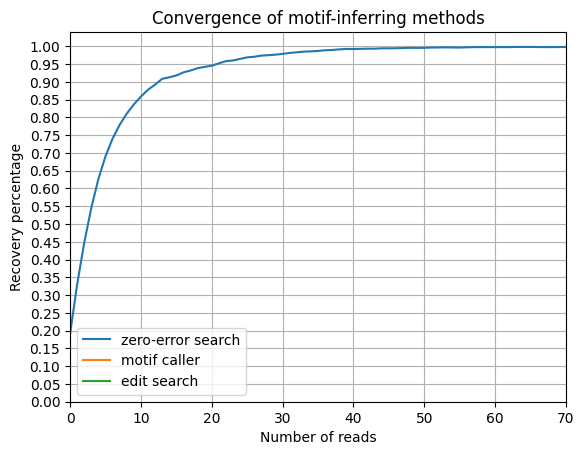

In [47]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(avg_search, label='zero-error search')
plt.plot(avg_caller, label='motif caller')
plt.plot(avg_edit, label='edit search')
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.05))
#plt.xticks(np.arange(0, 200, 2))
plt.xlim(0, 70)
plt.xlabel("Number of reads")
plt.ylabel("Recovery percentage")
plt.title("Convergence of motif-inferring methods")
plt.legend()

### Evaluating zero-error search

In [43]:

def sort_library_motif_transcript(library_prediction):
    """Sorts library motif transcripts while fixing for typos, by looking at the payloads to get the best orientation matches"""

    sorted_prediction = [[] for i in range(10)]

    split_library_prediction = library_prediction.split('|')

    #print(split_library_prediction)
    for i in split_library_prediction:

        if len(i) < 8:
            continue
        # searching for the 10
        motif_found = int(i[-1])
        cycle_address = None  # starts from 1 there and from 0 here
        if i[-4] == '1':
            if i[-3] == '0':
                cycle_address = 10
                sorted_prediction[cycle_address - 1].append(motif_found)
        elif i[-4] == '9':
            continue
        else:
            cycle_address = int(i[-3])
            sorted_prediction[cycle_address - 1].append(motif_found)

    return sorted_prediction
    

In [5]:
import pandas as pd

In [44]:
ms_df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\sequencing_runs\01-13\01-13-test.pkl")

In [45]:
lib_motifs = ms_df['library_motif'].tolist()
read_id_arr = ms_df['read_id'].tolist()

In [46]:
motif_seq_arr = []
read_ids_arr = []

for i, j in zip(lib_motifs, read_id_arr):
    try:
        motif_seq = sort_library_motif_transcript(i)
        motif_seq_arr.append(motif_seq)
        read_ids_arr.append(j)
    except:
        print(f"Exception at {i}")


Exception at ltm8_5x4|ltm8_6x8|ltm8_7x4|ltm8_10x2|ltm8_10x2|ltm8_0x1|ltm8_1x6|ltm8_99x1|ltm8_98x2|ltm8_94x6|ltm8_93x7|ltm8_90x11|ltm8_89x11


In [47]:
merged_df = pd.merge(ms_df, pd.DataFrame({
    "read_id": read_ids_arr,
    "motif_seq": motif_seq_arr
}))

In [22]:
merged_df

,Unnamed: 0,ONT_Barcode,read_id,HW_Address,orientation,start_end,library_motif,payload,squiggle,motif_seq
0,37,barcode93,e3ba2eaf-012a-4126-bdc9-6fd685f227df,barcode_external01_internal08,+|+|+|+|+|+|+|+,81-130|119-143|171-195|223-247|273-297|323-347...,ltm8_1x1|ltm8_98x2|ltm8_97x3|ltm8_96x4|ltm8_95...,"[[2, 4, 6, 8], [1, 2, 3, 4], [1, 4, 6, 7], [1,...","[580, 504, 523, 493, 516, 504, 510, 500, 502, ...","[[1], [], [], [1], [7], [], [], [], [], []]"
1,38,barcode93,a1651482-f5b1-44ae-b3c1-cfb20cebe0ef,barcode_external05_internal03,+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+,87-123|124-173|175-224|112-136|213-237|364-388...,ltm8_0x1|ltm8_1x5|ltm8_2x3|ltm8_99x1|ltm8_97x3...,"[[1, 4, 6, 8], [2, 4, 5, 8], [1, 4, 6, 7], [2,...","[483, 496, 509, 518, 522, 506, 500, 496, 507, ...","[[5], [3], [], [], [4], [2], [3, 7], [3], [], ..."
2,173,barcode93,bb77081b-39bf-4bcf-b94c-2a2db52ba59e,barcode_external06_internal02,+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+|+,81-117|106-130|155-179|206-230|256-280|306-330...,ltm8_0x1|ltm8_99x1|ltm8_98x2|ltm8_97x3|ltm8_96...,"[[2, 3, 5, 7], [2, 4, 7, 8], [1, 3, 4, 6], [1,...","[507, 498, 492, 507, 501, 504, 483, 477, 499, ...","[[], [], [3], [4], [3], [3], [4], [6], [4], [1..."
3,216,barcode93,bce5bd0f-304a-4038-ae14-3bda2c982a45,barcode_external05_internal03,-,221-245,ltm8_99x1,"[[1, 4, 6, 8], [2, 4, 5, 8], [1, 4, 6, 7], [2,...","[504, 484, 484, 474, 492, 468, 487, 475, 485, ...","[[], [], [], [], [], [], [], [], [], []]"
4,328,barcode93,87c17d40-8da8-4298-940a-353cf44f50a7,barcode_external06_internal02,-|-|-|-|-|-|-|-|-|-|-|-|-|-,544-593|494-543|581-605|531-555|481-505|432-45...,ltm8_1x6|ltm8_2x2|ltm8_99x1|ltm8_98x2|ltm8_97x...,"[[2, 3, 5, 7], [2, 4, 7, 8], [1, 3, 4, 6], [1,...","[668, 439, 470, 540, 519, 518, 520, 502, 502, ...","[[6], [2], [], [4], [], [7], [], [1], [], []]"
...,...,...,...,...,...,...,...,...,...,...
10695,725040,barcode93,ba75236a-5316-4434-83f1-75a3b09c2269,barcode_external05_internal01,+|+|+|+|+|+,164-188|214-238|312-336|176-225|226-275|324-373,ltm8_97x3|ltm8_96x4|ltm8_94x6|ltm8_3x2|ltm8_4x...,"[[1, 2, 3, 8], [1, 2, 4, 5], [1, 3, 4, 5], [2,...","[520, 496, 509, 532, 530, 525, 508, 513, 512, ...","[[], [], [2], [4], [], [6], [], [], [], []]"
10696,725079,barcode93,3835fde7-7dfe-405b-9cce-823e51454cd4,barcode_external05_internal01,-,97-121,ltm8_92x8,"[[1, 2, 3, 8], [1, 2, 4, 5], [1, 3, 4, 5], [2,...","[344, 385, 393, 387, 397, 394, 389, 304, 280, ...","[[], [], [], [], [], [], [], [], [], []]"
10697,725140,barcode93,cc6a47d1-ee55-47aa-b880-ce9248adacc5,barcode_external01_internal08,+|+|+|+|+|+|+|+|+|+|+,113-162|101-125|151-175|201-225|251-275|349-37...,ltm8_1x1|ltm8_99x1|ltm8_98x2|ltm8_97x3|ltm8_96...,"[[2, 4, 6, 8], [1, 2, 3, 4], [1, 4, 6, 7], [1,...","[448, 480, 509, 545, 667, 583, 584, 573, 561, ...","[[1], [], [8], [], [], [], [7], [], [], []]"
10698,725202,barcode93,8e82f6b3-30fd-4031-bd6f-b047ebe561aa,barcode_external01_internal08,+|+|+|+|+|+|+|+,101-150|89-113|139-163|189-213|291-315|388-412...,ltm8_1x1|ltm8_99x1|ltm8_98x2|ltm8_97x3|ltm8_95...,"[[2, 4, 6, 8], [1, 2, 3, 4], [1, 4, 6, 7], [1,...","[389, 386, 368, 377, 369, 388, 379, 387, 369, ...","[[1], [], [], [], [], [], [], [], [], []]"


### Checking average quality

In [55]:
basepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\fastq\EIC01-01-1280\FASTQ(pass_fail_logs)\fail"

In [34]:
from Bio import SeqIO
import numpy as np
import os
from tqdm import tqdm

In [52]:

from Bio import SeqIO

avg_qs = []
for file in tqdm(os.listdir(basepath)):
    for record in SeqIO.parse(os.path.join(basepath, file), "fastq"):
        score=record.letter_annotations["phred_quality"]
        avg_qs.append(np.mean(score))
    

 10%|▉         | 53/544 [00:10<01:39,  4.93it/s]


KeyboardInterrupt: 

In [53]:
np.mean(avg_qs)

np.float64(20.855998563182613)

In [54]:
pass_sizes = []
fail_sizes = []

for file in tqdm(os.listdir(basepath)):
    pass_sizes.append(os.path.getsize(os.path.join(basepath, file)))

100%|██████████| 544/544 [00:00<00:00, 17000.22it/s]


In [57]:

fail_sizes = []
for file in tqdm(os.listdir(basepath)[:544]):
    fail_sizes.append(os.path.getsize(os.path.join(basepath, file)))

100%|██████████| 544/544 [00:00<00:00, 13952.12it/s]


In [58]:
np.mean(pass_sizes) / (np.mean(pass_sizes) + np.mean(fail_sizes))

np.float64(0.6383195336922252)

In [19]:
np.mean(qualities)

np.float64(22.354282676989925)

In [1]:
import pandas as pd


motif_search_coded = pd.read_csv(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\empirical\motif_search_barcoded.csv")